In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import json
import os
import datetime
from collections import deque
import numpy as np

BCM(M)-BCM(D) 49 videos: LOPO_test_output_dir has raw json by video. Diagnostic files in LOPO_TEST_allvids
UCLA(M)-BCM(D) 49 videos:UCLA_LOPO_out has raw json by video. Dignostic files in UCLA LOPO

Some more advanced ideas: can pass predictions to a hidden markov model to estimate the change that the model is in a 'seizure state' based on teh current list of predictions.

In [44]:
# Pull data from JSON files
def extract_data(path):
    with open(path) as f:
        data = json.load(f)
    return data

# Find video name in filepath
labels_pattern = re.compile(r'video_.*')
def video_from_path(path):
    str_match = labels_pattern.search(path)
    video = str_match.group()[:-16]
    return video

In [45]:
def extract_folder_json(directory:str):
    data = []
    videos = []
    paths = []
    for p,d,f in os.walk(directory):
        for sub_f in f:
            if sub_f[-4:] == "json":
                path = os.path.realpath(os.path.join(p,sub_f))
                data.append(extract_data(path))
                videos.append(video_from_path(path))
                paths.append(path)

    return videos, data, paths
bcm_videos, bcm_data, bcm_paths = extract_folder_json('model_data')
ucla_videos, ucla_data, ucla_paths = extract_folder_json('UCLA_JSON')

In [46]:
predictions_df = pd.DataFrame({'Video_Name': bcm_videos, 'Predictions': bcm_data, 'Paths': bcm_paths})
predictions_ucla = pd.DataFrame({'Video_Name': ucla_videos, 'Predictions': ucla_data, 'Paths': ucla_paths})

In [47]:
predictions_df['Seizure_Prob'] = predictions_df['Predictions'].map(lambda x: [y[1] for y in x])
predictions_df.drop(columns=['Predictions'], inplace=True)
predictions_ucla['Seizure_Prob'] = predictions_ucla['Predictions'].map(lambda x: [y[1] for y in x])
predictions_ucla.drop(columns=['Predictions'], inplace=True)

In [48]:
def naieve_sma(preds:list, k):
    average = np.convolve(preds, np.ones(k)/k, mode='same')
    return average
    # Uses sliding convolution of a filter compsed of k entries of 1/k to calculate the SMA.
    # Boundary effects are not accounted for

def moving_median(data:list, k):
    """
    Compute the moving median over n consecutive datapoints.
    
    Args:
        data (list): Ordered list of datapoints.
        k (int): Window size for moving median.
    
    Returns:
        list: List of moving median values with the same length as input data.
    """
    if k < 1:
        raise ValueError("Window size 'k' must be at least 1.")
    
    medians = []
    window = deque(maxlen=k)
    
    for point in data:
        window.append(point)
        medians.append(np.median(window))
    
    return medians

import numpy as np
from collections import deque

def weighted_moving_median(data: list, k: int, cutoffs:list=[0.1, 0.35, 0.65, 0.9]):
    """
    Compute the weighted moving median over n consecutive datapoints.
    Certain predictions (e.g. <0.1 or >0.5 are heavily weighted, while uncertain predictions (0.35, 0.65) are penalized)

    Args:
        data (list): Ordered list of datapoints.
        k (int): Window size for moving median.
    
    Returns:
        list: List of weighted moving median values with the same length as input data.
    """
    if k < 1:
        raise ValueError("Window size 'k' must be at least 1.")
    
    medians = []
    window = deque(maxlen=k)
    
    for point in data:
        if point <= cutoffs[0]: weight = 3
        elif cutoffs[0] < point <= cutoffs[1]: weight = 1
        elif cutoffs[1] < point < cutoffs[2]: weight = 0.5
        elif cutoffs[2] <= point < cutoffs[3]: weight = 1
        elif cutoffs[3] <= point: weight = 5

        window.append((point, weight))
        
        # Extract values and weights from the current window
        values, weights = zip(*window)
        
        # Compute weighted median
        sorted_indices = np.argsort(values)
        sorted_values = np.array(values)[sorted_indices]
        sorted_weights = np.array(weights)[sorted_indices]
        cumulative_weights = np.cumsum(sorted_weights)
        
        # Find the weighted median
        total_weight = cumulative_weights[-1]
        median_index = np.searchsorted(cumulative_weights, total_weight / 2)
        medians.append(sorted_values[median_index])
    
    return medians


def weighted_moving_average(data:list, k):
    """
    Compute the moving average weighted by the rate of change over n consecutive datapoints.
    
    Args:
        data (list): Ordered list of datapoints.
        k (int): Window size for the weighted moving average.
    
    Returns:
        list: List of weighted moving average values with the same length as input data.
    """
    if k < 1:
        raise ValueError("Window size 'n' must be at least 1.")
    
    if len(data) < 2:
        return data  # Not enough data points for rate of change weighting.
    
    averages = []
    window = deque(maxlen=k)
    
    for i in range(len(data)):
        if i > 0:
            # Compute the rate of change
            rate_of_change = abs(data[i] - data[i - 1])
        else:
            rate_of_change = 1  # Default weight for the first point.
        
        # Add the rate-weighted value to the window
        weighted_value = data[i] * rate_of_change
        window.append(weighted_value)
        
        # Compute weighted average
        weights = [abs(data[j] - data[j - 1]) if j > 0 else 1 for j in range(max(0, i - k + 1), i + 1)]
        weighted_avg = sum(window) / sum(weights)
        
        averages.append(weighted_avg)
    
    return averages


In [49]:
patients = {
    'Patient 1': '06348578',
    'Videos 1': [
    ('Videos/7942GT00.mp4', 306, 365, '7942GT00', 'hi'),
    ('Videos/7942GU00.mp4', 300, 362, '7942GU00', 'hi'),
    ('Videos/7942GZ00.mp4', 748, 806, '7942GZ00', 'hi'),
    ],
    'Patient 2': '05501184',
    'Videos 2': [
    ('Videos/79537W00.mp4', 380, 440, '79537W00', 'lo'),
    ('Videos/79538201.mp4', 236, 313, '79538201', 'no'),
    ('Videos/79538301.mp4', 280, 345, '79538301', 'no'),
    ('Videos/79648S00.mp4', 540, 622, '79648S00', 'mod'),
    ('Videos/79433800.mp4', 363, 483, '79433800', 'no'),
    ('Videos/7913ZY00.mp4', 540, 618, '7913ZY00', 'mod'),
    ],
    'Patient 3': '05418761',
    'Videos 3': [
    ('Videos/7972M300.mp4', 326, 420, '7972M300', 'mod'),
    ('Videos/7972M401.mp4', 112, 158, '7972M401', 'lo'),
    ],
    'Patient 4': '06394294',
    'Videos 4': [
    ('Videos/7942QQ00.mp4', 350, 420, '7942QQ00', 'hi'),
    ('Videos/7942QR00.mp4', 365, 445, '7942QR00', 'hi'),
    ('Videos/00200200.mp4', 144, 233, '00200200', 'mod'),
    ],
    'Patient 5': '05531053',
    'Videos 5': [
    ('Videos/00105G00.mp4', 152, 212, '00105G00', 'lo'),
    ('Videos/00105F00.mp4', 153, 215, '00105F00', 'no'),
    ('Videos/79626800.mp4', 245, 315, '79626800', 'lo'),
    ],
    'Patient 6': '05167183',
    'Videos 6': [
    ('Videos/7951QL00.mp4', 325, 370, '7951QL00', 'lo'),
    ],
    'Patient 7': '05467817',
    'Videos 7': [
    ('Videos/7971Q500.mp4', 292, 371, '7971Q500', 'hi'),
    ],
    'Patient 8': '05323733',
    'Videos 8': [
    ('Videos/7971UI00.mp4', 663, 720, '7971UI00', 'mod'),
    ],
    'Patient 9': '05271491',
    'Videos 9': [
    ('Videos/7941OZ00.mp4', 366, 410, '7941OZ00', 'lo'),
    ('Videos/7941OY00.mp4', 187, 232, '7941OY00', 'lo'),
    ],
    'Patient 10': '05486196',
    'Videos 10': [
    ('Videos/7941M700.mp4', 177, 255, '7941M700', 'mod'),
    ],
    'Patient 11': '05514820',
    'Videos 11': [
    ('Videos/7941LY00.mp4', 314, 364, '7941LY00', 'mod'),
    ],
    'Patient 12': '05513119',
    'Videos 12': [
    ('Videos/00200100.mp4', 154, 235, '00200100', 'lo'),
    ('Videos/00105200.mp4', 280, 340, '00105200', 'lo'),
    ('Videos/00105205.mp4', 72, 110, '00105205', 'no'),
    ('Videos/00105207.mp4', 257, 285, '00105207', 'no'),
    ],
    'Patient 13': '02267738',
    'Videos 13': [
    ('Videos/7941E400.mp4', 280, 320, '7941E400', 'lo'),
    ('Videos/7941EC00.mp4', 175, 250, '7941EC00', 'mod'),
    ('Videos/7941ED00.mp4', 209, 250, '7941ED00', 'lo'),
    ],
    'Patient 15': '05447543',
    'Videos 15': [
    ('Videos/7941D100.mp4', 136, 170, '7941D100', 'hi'),
    ('Videos/7941D200.mp4', 177, 221, '7941D200', 'hi'),
    ('Videos/7941D300.mp4', 190, 221, '7941D300', 'hi'),
    ('Videos/7941D400.mp4', 168, 207, '7941D400', 'mod'),
    ('Videos/7941D500.mp4', 209, 247, '7941D500', 'lo'),
    ('Videos/7941D600.mp4', 145, 185, '7941D600', 'lo'),
    ],
    'Patient 16': '02940398',
    'Videos 16': [
    ('Videos/79411N00.mp4', 241, 285, '79411N00', 'no'),
    ('Videos/79411Q00.mp4', 300, 370, '79411Q00', 'lo'),
    ('Videos/79411T00.mp4', 200, 255, '79411T00', 'no'),
    ('Videos/79411U00.mp4', 0, 40, '79411U00', 'no'),
    ('Videos/79412000.mp4', 275, 300, '79412000', 'no'),
    ],
    'Patient 17': '02268547',
    'Videos 17': [
    ('Videos/7940K700.mp4', 130, 192, '7940K700', 'hi'),
    ],
    'Patient 18': '05454991',
    'Videos 18': [
    ('Videos/79410R00.mp4', 360, 425, '79410R00', 'mod'),
    ],
    'Patient 19': '05497695',
    'Videos 19': [
    ('Videos/7941E901.mp4', 325, 391, '7941E901', 'hi'),
    ('Videos/7941EA00.mp4', 330, 405, '7941EA00', 'hi'),
    ('Videos/7971C500.mp4', 183, 252, '7971C500', 'mod'),
    ('Videos/7971C800.mp4', 163, 222, '7971C800', 'lo'),
    ('Videos/7971C700.mp4', 127, 194, '7971C700', 'mod'),
    ],
    'Patient 20': '05463487',
    'Videos 20': [
    ('Videos/79519000.mp4', 625, 700, '79519000', 'mod'),
    ],
    'Patient 21': '05235825',
    'Videos 21': [
    ('Videos/79719R00.mp4', 65, 130, '79719R00', 'mod'),
    ],
    'Patient 22': '05352576',
    'Videos 22': [
    ('Videos/7970IA00.mp4', 170, 250, '7970IA00', 'hi'),
    ('Videos/7940HO00.mp4', 252, 320, '7940HO00', 'mod'),
    ('Videos/7940HU00.mp4', 130, 214, '7940HU00', 'hi'),
    ('Videos/22200Q01.mp4', 62, 131, '22200Q01', 'hi'),
    ('Videos/22200S00.mp4', 82, 155, '22200S00', 'mod'),
    ('Videos/22200T00.mp4', 72, 120, '22200T00', 'lo'),
    ],
    'Patient 23': '02604950',
    'Videos 23': [
    ('Videos/7950J900.mp4', 145, 203, '7950J900', 'no'),
    ('Videos/7950JA00.mp4', 230, 280, '7950JA00', 'no'),
    ],
    'Patient 24': '05512494',
    'Videos 24': [
    ('Videos/7971H000.mp4', 97, 140, '7971H000', 'mod'),
    ],
    'Patient 25': '01394111',
    'Videos 25': [
    ('Videos/7960BY00.mp4', 350, 437, '7960BY00', 'lo'),
    ],
    'Patient 26': '02767430',
    'Videos 26': [
    ('Videos/22200000.mp4', 225, 290, '22200000', 'lo'),
    ],
    'Patient 29': '06375932',
    'Videos 29': [
    ('Videos/00100S00.mp4', 462, 475, '00100S00', 'lo'),
    ],
    'Patient 33': '05489744',
    'Videos 33': [
    ('Videos/7941CO00.mp4', 372, 470, '7941CO00', 'mod'),
    ('Videos/7951EX00.mp4', 170, 295, '7951EX00', 'mod'),
    ],
    'Patient 35': '06381028',
    'Videos 35': [
    ('Videos/7953A100.mp4', 309, 375, '7953A100', 'lo'),
    ('Videos/7953A200.mp4', 405, 510, '7953A200', 'lo'),
    ('Videos/7953A400.mp4', 252, 296, '7953A400', 'lo'),
    ('Videos/7953A501.mp4', 30, 115, '7953A501', 'lo'),
    ],
    'Patient 36': '00582992',
    'Videos 36': [
    ('Videos/7952GP00.mp4', 1110, 1308, '7952GP00', 'mod'),
    ],
    'Patient 37': '06338772',
    'Videos 37': [
    ('Videos/7972OT00.mp4', 405, 470, '7972OT00', 'mod'),
    ],
    'Patient 38': '05109836',
    'Videos 38': [
    ('Videos/7952DG00.mp4', 315, 385, '7952DG00', 'mod'),
    ('Videos/7952DO00.mp4', 315, 377, '7952DO00', 'lo'),
    ('Videos/7952DP00.mp4', 315, 376, '7952DP00', 'mod'),
    ('Videos/00108500.mp4', 492, 540, '00108500', 'mod'),
    ('Videos/00108700.mp4', 233, 295, '00108700', 'mod'),
    ],
    'Patient 39': '06452950',
    'Videos 39': [
    ('Videos/7964JU00.mp4', 427, 488, '7964JU00', 'mod'),
    ],
    'Patient 40': '06431398',
    'Videos 40': [
    ('Videos/79647600.mp4', 443, 485, '79647600', 'no'),
    ('Videos/79536800.mp4', 434, 470, '79536800', 'no'),
    ],
    'Patient 42': '00913367',
    'Videos 42': [
    ('Videos/00105B00.mp4', 110, 151, '00105B00', 'mod'),
    ('Videos/00105C00.mp4', 135, 192, '00105C00', 'mod'),
    ('Videos/7962T700.mp4', 185, 260, '7962T700', 'lo'),
    ('Videos/7962T900.mp4', 192, 253, '7962T900', 'lo'),
    ('Videos/7962TA00.mp4', 146, 198, '7962TA00', 'mod'),
    ],
    'Patient 43': '05023116',
    'Videos 43': [
    ('Videos/7963TA00.mp4', 310, 375, '7963TA00', 'lo'),
    ('Videos/7963TB00.mp4', 362, 400, '7963TB00', 'lo'),
    ('Videos/7963TC00.mp4', 170, 215, '7963TC00', 'lo'),
    ('Videos/7963TF00.mp4', 270, 310, '7963TF00', 'no'),
    ]
}

patients_UCLA = {
    'Patient 1': 's0001', 'Videos 1': [('Videos/S0001sz01.mp4', 246.2, 313.2, 's0001', 'na')],
    'Patient 2': 's0002', 'Videos 2': [('Videos/S0002sz01.mp4', 217, 278, 's0002', 'na')],
    'Patient 3': 's0003', 'Videos 3': [('Videos/S0003sz02.mp4', 108.9, 215.9, 's0003', 'na')],
    'Patient 4': 's0004', 'Videos 4': [('Videos/S0004sz01.mp4', 183.2, 260.2, 's0004', 'na')],
    'Patient 5': 's0005', 'Videos 5': [('Videos/S0005sz01.mp4', 221.2, 320.2, 's0005', 'na')],
    'Patient 6': 's0006', 'Videos 6': [('Videos/S0006sz01.mp4', 171.2, 224.2, 's0006', 'na')],
    'Patient 7': 's0007', 'Videos 7': [('Videos/S0007sz01.mp4', 234.1, 299.1, 's0007', 'na')],
    'Patient 8': 's0008', 'Videos 8': [('Videos/S0008sz01.mp4', 85.1, 152.1, 's0008', 'na')],
    'Patient 9': 's0009', 'Videos 9': [('Videos/S0009sz01.mp4', 179, 254, 's0009', 'na')],
    'Patient 10': 's0010', 'Videos 10': [('Videos/S0010sz01.mp4', 200.1, 267.1, 's0010', 'na')],
    'Patient 11': 's0011', 'Videos 11': [('Videos/S0011sz01.mp4', 212.1, 343.1, 's0011', 'na')],
    'Patient 12': 's0012', 'Videos 12': [('Videos/S0012sz01.mp4', 128.2, 308.2, 's0012', 'na')],
    'Patient 13': 's0013', 'Videos 13': [('Videos/S0013sz01.mp4', 207.2, 307.2, 's0013', 'na')],
    'Patient 14': 's0014', 'Videos 14': [('Videos/S0014sz01.mp4', 216.2, 314.2, 's0014', 'na')],
    'Patient 15': 's0015', 'Videos 15': [('Videos/S0015sz01.mp4', 214.2, 624.2, 's0015', 'na')],
    'Patient 16': 's0016', 'Videos 16': [('Videos/S0016sz01.mp4', 210.1, 305.1, 's0016', 'na')],
    'Patient 17': 's0017', 'Videos 17': [('Videos/S0017sz01.mp4', 204.3, 276.3, 's0017', 'na')],
    'Patient 19': 's0019', 'Videos 19': [('Videos/S0019sz01.mp4', 671, 789, 's0019', 'na')],
    'Patient 20': 's0020', 'Videos 20': [('Videos/S0020sz01.mp4', 253.3, 383.3, 's0020', 'na')]
}

In [50]:
video_infos = []
video_infos_ucla = []

for k,v in patients.items():
    if 'Patient' in k:
        id = v
    elif 'Video' in k:
        no = re.findall(r'\d+', k)
        video_infos.append((int(no[0]), id, v))

for k,v in patients_UCLA.items():
    if 'Patient' in k:
        id = v
    elif 'Video' in k:
        no = re.findall(r'\d+', k)
        video_infos_ucla.append((int(no[0]), id, v))

def match_video_data(data, video_name):
    for _, _, video_infos in data:
        for video_info in video_infos:
            if any(video_name in str(field) for field in video_info):
                return video_info
    return None
def generate_seizure_prediction_array(no_predictions, video_time, true_seizure_interval):
    """
    Generate an array with 0's and 1's based on the seizure interval proportion.
    
    Args:
        no_predictions (int): The total number of predictions (length of the output array).
        video_time (int): The total video duration in seconds.
        true_seizure_interval (tuple): A tuple (start_seconds, end_seconds) representing the seizure interval.
    
    Returns:
        np.ndarray: An array of length `no_predictions` with 0's and 1's.
    """
    start_seconds, end_seconds = true_seizure_interval

    if start_seconds < 0 or end_seconds > video_time or start_seconds > end_seconds:
        raise ValueError("Invalid seizure interval or video time.")

    # Calculate the corresponding indices in the array for the seizure interval
    seizure_start_idx = int((start_seconds / video_time) * no_predictions)
    seizure_end_idx = int((end_seconds / video_time) * no_predictions)
    
    # Initialize the array with 0's
    prediction_array = np.zeros(no_predictions, dtype=int)
    
    # Set 1's for the indices within the seizure interval
    prediction_array[seizure_start_idx:seizure_end_idx] = 1
    
    return prediction_array

In [51]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

seizure_color = "#a30324"
# non_seizure_color = "#002157"
non_seizure_color="#bacfec"
# seizure_color="#ce8080"
pred_cmap = LinearSegmentedColormap.from_list("pred_colormap", [non_seizure_color, "#7a5071", seizure_color])
colors = [non_seizure_color, seizure_color]
cmap = ListedColormap(colors)

def seizure_predictions(row, av_type, k:int=5, show_plot:bool=False, df = predictions_df, video_data = 'BCM', save:bool=False, text_scale:int=1, title_off:bool=False):
    """
    Plots the predictions of the model for given video.
    
    **Args**
    - `row`: row of dataframe to be plotted
    - `av_type`: type of moving average to employ. Valid arguments are 'sma', 'mm', and 'wma'.
    - `k`: window size for averaging functions. Default = 5
    - `show_plot`: display the graph of scores v. predictions. Default = `False`
    """

    # Naming got a bit convoluted (along w/ everything else) after adding UCLA model stuff
    if row < 48 and video_data == 'BCM': title = 'SameSiteBCM-M'
    if row >= 48 and video_data == 'BCM': title = 'CrossSiteBCM-M'
    if row < 19 and video_data == 'UCLA': title = 'SameSiteUCLA-M'
    if row >= 19 and video_data == 'UCLA': title = 'CrossSiteUCLA-M'
    if video_data == 'BCM': video_name = str(df['Video_Name'].iloc[row][-8:])
    if video_data == 'UCLA': video_name = str(df['Video_Name'].iloc[row][-5:])
    title = title + " - " + video_name

    seizure_chance = df['Seizure_Prob'].iloc[row]
    t = np.linspace(0,len(seizure_chance)*3,num = len(seizure_chance))
    if video_data == 'BCM': actual = match_video_data(video_infos, video_name)[1:3]; deg_of_movement = match_video_data(video_infos, video_name)[4]
    if video_data == 'UCLA': actual = match_video_data(video_infos_ucla, video_name)[1:3]; deg_of_movement = match_video_data(video_infos_ucla, video_name)[4]
    

    scores = generate_seizure_prediction_array(len(t), len(t)*3, (actual[0], actual[1]))

    if av_type:
        if av_type == "sma":
            average = naieve_sma(seizure_chance, k)
        if av_type == "mm":
            average = moving_median(seizure_chance, k)
        if av_type == "wma":
            average = weighted_moving_average(seizure_chance, k)
        if av_type == "wmm":
            average = weighted_moving_median(seizure_chance, k)
    else: ValueError("Argument `av_type` is required. Valid arguments are 'sma', 'mm', 'wmm', and 'wma'")
    
    if show_plot:   
        plt.imshow(np.expand_dims(scores, axis=0), cmap=cmap, aspect='auto', extent=(0, max(t), 0, 1), alpha=0.3)
        plt.scatter(t,seizure_chance, c=seizure_chance, cmap=pred_cmap, vmin=0, vmax=1, alpha=1)
        plt.plot(t, average, alpha=0.8, linewidth=2, color="#7a5071")
        if not title_off: plt.title(title, fontsize=12*text_scale)
        plt.xlabel('Time (s)', fontsize=12*text_scale)
        plt.ylabel('Probability of seizure', fontsize=12*text_scale)
        plt.tick_params(axis='both', labelsize=8*text_scale*1.2)
        plt.hlines(0.5,0, max(t), linestyles='--', colors='grey')

        if save:
            # legend_elements = [
            #     Line2D([0], [0], color='#7a5071', lw=2, label='Weighted Moving Median'),
            #     Line2D([0], [0], color='grey', linestyle='--', lw=1, label='Prediction Threshold'),
            #     mpatches.Patch(color=non_seizure_color, alpha = 0.3, label='True Non-Seizure'),
            #     mpatches.Patch(color=seizure_color, alpha = 0.3, label='True Seizure'),
            #     Line2D([0], [0], marker='o', color='w', markerfacecolor=pred_cmap(0), markersize=10, label='Nonseizure (0)'),
            #     Line2D([0], [0], marker='o', color='w', markerfacecolor=pred_cmap(0.25), markersize=10, label=''),
            #     Line2D([0], [0], marker='o', color='w', markerfacecolor=pred_cmap(0.5), markersize=10, label=''),
            #     Line2D([0], [0], marker='o', color='w', markerfacecolor=pred_cmap(0.75), markersize=10, label=''),
            #     Line2D([0], [0], marker='o', color='w', markerfacecolor=pred_cmap(0.99), markersize=10, label='Seizure (1)'),
            # ]
            # plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title='Legend', frameon=False)
            plt.savefig(f'{title}.png', dpi=1000, bbox_inches='tight')

        plt.show()

    # Collect results
    seizure_len = actual[1] - actual[0]
    results_dict = {
        'Total_Predictions': len(seizure_chance),
        'Video_Time': max(t),
        'True_Seizure': (actual[0], actual[1]),
        'Seizure_Len': seizure_len,
        'Seizure_Prop': seizure_len/max(t),
        'Degree_Movement': deg_of_movement,
        'Scores': scores,
        'Preds': seizure_chance,
        'Aggregate': average,
        'fig': plt.gcf(),
        'Video_name': video_name
    }

    return results_dict

In [53]:
# test_results = seizure_predictions(74, av_type='wmm', k=8, show_plot=True, save=True, text_scale=1.7, title_off=True)

In [54]:
# test_results_ucla = seizure_predictions(11, av_type='wmm', k=8, show_plot=True, df=predictions_ucla, video_data='UCLA')

In [55]:
# Add scores:
for df in [predictions_df, predictions_ucla]:
    pred_diffs = []
    for row in range(0, len(df)):
        preds_scores = seizure_predictions(row, av_type='mm')
        preds = preds_scores["Preds"]
        scores = preds_scores["Scores"]
        pred_diffs.append(preds-scores)
    df['Pred_diffs'] = pred_diffs

<Figure size 640x480 with 0 Axes>

In [57]:
# NOTE: False alarms
# A false alarm is triggered if
# 1. Moving aggregate crosses 0.5 for at least 3 consecutive predictions
# 2. The true score is 0 durring the corresponding time window [-60, +120]. i.e. if the alarm sets of within a minute before seizure, not a false alarm. Likewise 2 minutes after the seizure are ok 
# 3. There has not been an active alarm in the past 60 seconds

In [108]:
def count_false_alarms(moving_aggregate, true_score, s):
    """
    Count false alarms based on moving aggregate and true score.
    
    Args:
        moving_aggregate (list or np.ndarray): Array of moving aggregate scores.
        true_score (list or np.ndarray): Array of true scores.
        s (int): Number of seconds each prediction corresponds to.
    
    Returns:
        dict: A dictionary with the number of false alarms, details of each alarm, 
              and false alarms per hour.
    """
    # Initialize variables
    false_alarms = []
    last_alarm_time = -float('inf')  # To track the last alarm time in seconds
    active_alarm = False

    n = len(moving_aggregate)
    for i in range(n):
        if i >= 2 and all(moving_aggregate[i - j] > 0.5 for j in range(3)):
            start_window = max(0, i // s)
            end_window = min(n, i + 60 // s)
            
            if all(true_score[j] == 0 for j in range(start_window, end_window)):
                current_time = i * s  # Time in seconds for the current prediction
                
                # Check if no active alarm in the past 60 seconds
                if current_time - last_alarm_time >= 60:
                    # Log the alarm details
                    alarm_start = (i - 2) * s  # Time when the alarm started (3 steps ago)
                    alarm_end = i * s  # Time when the alarm ends
                    alarm_duration = alarm_end - alarm_start
                    
                    false_alarms.append({
                        "start_time": alarm_start,
                        "end_time": alarm_end,
                        "duration": alarm_duration
                    })
                    
                    last_alarm_time = current_time
                    active_alarm = True
        else:
            active_alarm = False

    # Calculate the number of false alarms per hour
    total_video_time = n * s  # Total video time in seconds
    false_alarms_per_hour = (len(false_alarms) / total_video_time) * 3600  # False alarms per hour

    # Prepare the result dictionary
    result = {
        "num_false_alarms": len(false_alarms),
        "alarm_details": false_alarms,
        "total_video_time": total_video_time,
        "false_alarms_per_hour": false_alarms_per_hour
    }

    return result
def count_false_alarms_and_seizure_metrics(moving_aggregate, true_score, s):
    """
    Count false alarms and calculate seizure detection metrics.

    Args:
        moving_aggregate (list or np.ndarray): Array of moving aggregate scores.
        true_score (list or np.ndarray): Array of true scores (1 = seizure, 0 = no seizure).
        s (int): Number of seconds each prediction corresponds to.

    Returns:
        dict: A dictionary with metrics for false alarms, missed seizures, and detection latency.
    """
    # Initialize variables
    false_alarms = []
    last_alarm_time = -float('inf')  # To track the last alarm time in seconds
    missed_seizures = 0
    detection_latencies = []
    active_alarm = False

    n = len(moving_aggregate)

    # Infer seizure periods from the true_score
    seizure_periods = []
    in_seizure = False
    start_time = None
    
    for i, score in enumerate(true_score):
        if score == 1 and not in_seizure:
            # Start of a seizure
            in_seizure = True
            start_time = i * s
        elif score == 0 and in_seizure:
            # End of a seizure
            in_seizure = False
            end_time = i * s
            seizure_periods.append((start_time, end_time))
    if in_seizure:
        # If true_score ends during a seizure
        seizure_periods.append((start_time, n * s))

    # False alarm detection
    for i in range(n):
        # Check if moving aggregate crosses 0.5 for at least 3 consecutive predictions
        if i >= 2 and all(moving_aggregate[i - j] > 0.5 for j in range(3)):
            # Define the corresponding time window [-40, +120]
            start_window = max(0, i - 60 // s)
            end_window = min(n, i + 120 // s)
            
            # Check if the true score is 0 during the time window
            if all(true_score[j] == 0 for j in range(start_window, end_window)):
                current_time = i * s  # Time in seconds for the current prediction
                
                # Check if no active alarm in the past 60 seconds
                if current_time - last_alarm_time >= 60:
                    # Log the alarm details
                    alarm_start = (i - 2) * s  # Time when the alarm started (3 steps ago)
                    alarm_end = i * s  # Time when the alarm ends
                    alarm_duration = alarm_end - alarm_start
                    
                    false_alarms.append({
                        "start_time": alarm_start,
                        "end_time": alarm_end,
                        "duration": alarm_duration
                    })
                    
                    # Update the last alarm time and activate alarm
                    last_alarm_time = current_time
                    active_alarm = True
        else:
            active_alarm = False

    # Seizure metrics calculation
    for start_time, end_time in seizure_periods:
        # Find corresponding indices in the moving_aggregate
        start_idx = start_time // s
        end_idx = end_time // s
        
        # Check if any moving average score > 0.5 during the seizure period
        detected = any(val > 0.5 for val in moving_aggregate[start_idx:end_idx])
        
        if detected:
            # Calculate detection latency (first time SMA > 0.5 during the seizure period)
            detection_idx = next(
                (i for i in range(start_idx, end_idx) if moving_aggregate[i] > 0.5), 
                None
            )
            latency = (detection_idx - start_idx) * s if detection_idx is not None else None
            detection_latencies.append(latency)
            if latency is None: missed_seizures += 1
        else:
            # If no SMA > 0.5, it is a missed seizure
            missed_seizures += 1

    # Calculate the number of false alarms per hour
    total_video_time = n * s  # Total video time in seconds
    false_alarms_per_hour = (len(false_alarms) / total_video_time) * 3600  # False alarms per hour

    # Prepare the result dictionary
    result = {
        "num_false_alarms": len(false_alarms),
        "alarm_details": false_alarms,
        "total_video_time": total_video_time,
        "false_alarms_per_hour": false_alarms_per_hour,
        "missed_seizures": missed_seizures,
        "detection_latencies": detection_latencies,
        "seizure_periods": seizure_periods
    }

    return result

In [109]:
def auto_false_alarm(row:int, av_type:str='mm', k:int=5, s:int=3, show_plot:bool=False, print_alarms:bool=False, df:pd.DataFrame = predictions_df,video_data:str='BCM'):
    results = seizure_predictions(row, av_type=av_type, k=k, show_plot=show_plot, df = df, video_data=video_data)
    alarms = count_false_alarms_and_seizure_metrics(results['Aggregate'], results['Scores'], s)
    fig = results['fig']
    if print_alarms:
        for k,v in alarms.items():
            print(f"{k}: {v}")
    return alarms, fig

In [110]:
# example_BCM,_ = auto_false_alarm(3, av_type='wmm', show_plot=True, print_alarms=False)

In [111]:
# example_UCLA = auto_false_alarm(3, av_type='wmm', show_plot=True, print_alarms=False, df=predictions_ucla, video_data='UCLA')

### Mega Plotter

In [112]:
def combine_seizure_predictions_sorted(
    av_type='sma', k: int = 5, nrows: int = 10, ncols: int = 10, 
    df: pd.DataFrame = predictions_df, video_data: str = 'BCM', 
    title: str = 'Seizure predictions across all BCM Videos',
    save_title: str = ''
):
    """
    Combines seizure prediction plots for all rows into a single large subplot grid,
    sorted by a weighted combination of metrics.

    **Args**
    - `av_type`: type of moving average to employ. Valid arguments are 'sma', 'mm', and 'wma'.
    - `k`: window size for averaging functions. Default = 5
    - `nrows`: number of rows in the subplot grid. Default = 10
    - `ncols`: number of columns in the subplot grid. Default = 10

    **Returns**
    - Matplotlib figure with sorted subplots
    """
    
    # Calculate scores for sorting
    def calculate_sort_score(row):
        alarm_info, _ = auto_false_alarm(row, av_type=av_type, k=k, show_plot=False, print_alarms=False, df=df, video_data=video_data)
        false_alarms = alarm_info['num_false_alarms']
        missed_seizures = alarm_info['missed_seizures']
        detection_latency = alarm_info['detection_latencies'][0] if alarm_info['detection_latencies'] else float('inf')
        video_length = len(seizure_predictions(row, av_type, k, show_plot=False, df=df, video_data=video_data)['Preds'])

        mean_diff = abs(np.mean(df.iloc[row]['Pred_diffs']))
        if missed_seizures > 0: detection_latency = 0

        # Weighted combination of metrics for sorting (high score = worse... goes to end!)
        score = (
            2 * mean_diff + 
            false_alarms + 
            80 * missed_seizures + 
            0.1 * detection_latency
        )
        return score

    df['sort_score'] = df.index.map(calculate_sort_score)
    sorted_df = df.sort_values(by='sort_score', ascending=True).reset_index(drop=True)

    fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))
    fig.suptitle(f'{title} (Moving Average: {av_type}, Window Size: {k})', fontsize=16)
    max_cells = len(sorted_df)
    axs_flat = axs.flatten()

    for row in range(min(max_cells, nrows * ncols)):
        alarm_info, _ = auto_false_alarm(row, av_type=av_type, k=k, show_plot=False, print_alarms=False, df=sorted_df, video_data=video_data)
        false_alarms = alarm_info['num_false_alarms']
        missed_seizures = alarm_info['missed_seizures']
        if alarm_info['detection_latencies']:
            latency = alarm_info['detection_latencies'][0]
        else:
            latency = "N/A"
        results = seizure_predictions(row, av_type, k, show_plot=False, df=sorted_df, video_data=video_data)
        ax = axs_flat[row]

        t = np.linspace(0, len(results['Preds']) * 3, num=len(results['Preds']))

        # Plot seizure scores background
        ax.imshow(
            np.expand_dims(results['Scores'], axis=0), cmap=cmap, aspect='auto', 
            extent=(0, max(t), 0, 1), alpha=0.3
        )

        ax.plot(t, results['Aggregate'], alpha=0.8, linewidth=2, color="#7a5071")

        ax.scatter(t, results['Preds'], c=results['Preds'], cmap=pred_cmap, vmin=0, vmax=1, alpha=1)

        ax.hlines(0.5, 0, max(t), linestyles='--', colors='grey')

        ax.set_title(
            f"{results['Video_name']} ({results['Video_Time']:.1f})s: {false_alarms}FA, {missed_seizures}MS, {latency}sDL", 
            fontsize=8
        )

        if row % ncols == 0:
            ax.set_ylabel('Probability', fontsize=8)
        if row // ncols == nrows - 1:
            ax.set_xlabel('Time (s)', fontsize=8)

        ax.tick_params(axis='both', which='major', labelsize=6)

    for row in range(min(max_cells, nrows * ncols), nrows * ncols):
        fig.delaxes(axs_flat[row])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(f'{save_title}.png', dpi=300)

    return fig


### All BCM Videos analyzed by BCM model (0:48) and UCLA model (:end)

<Figure size 640x480 with 0 Axes>

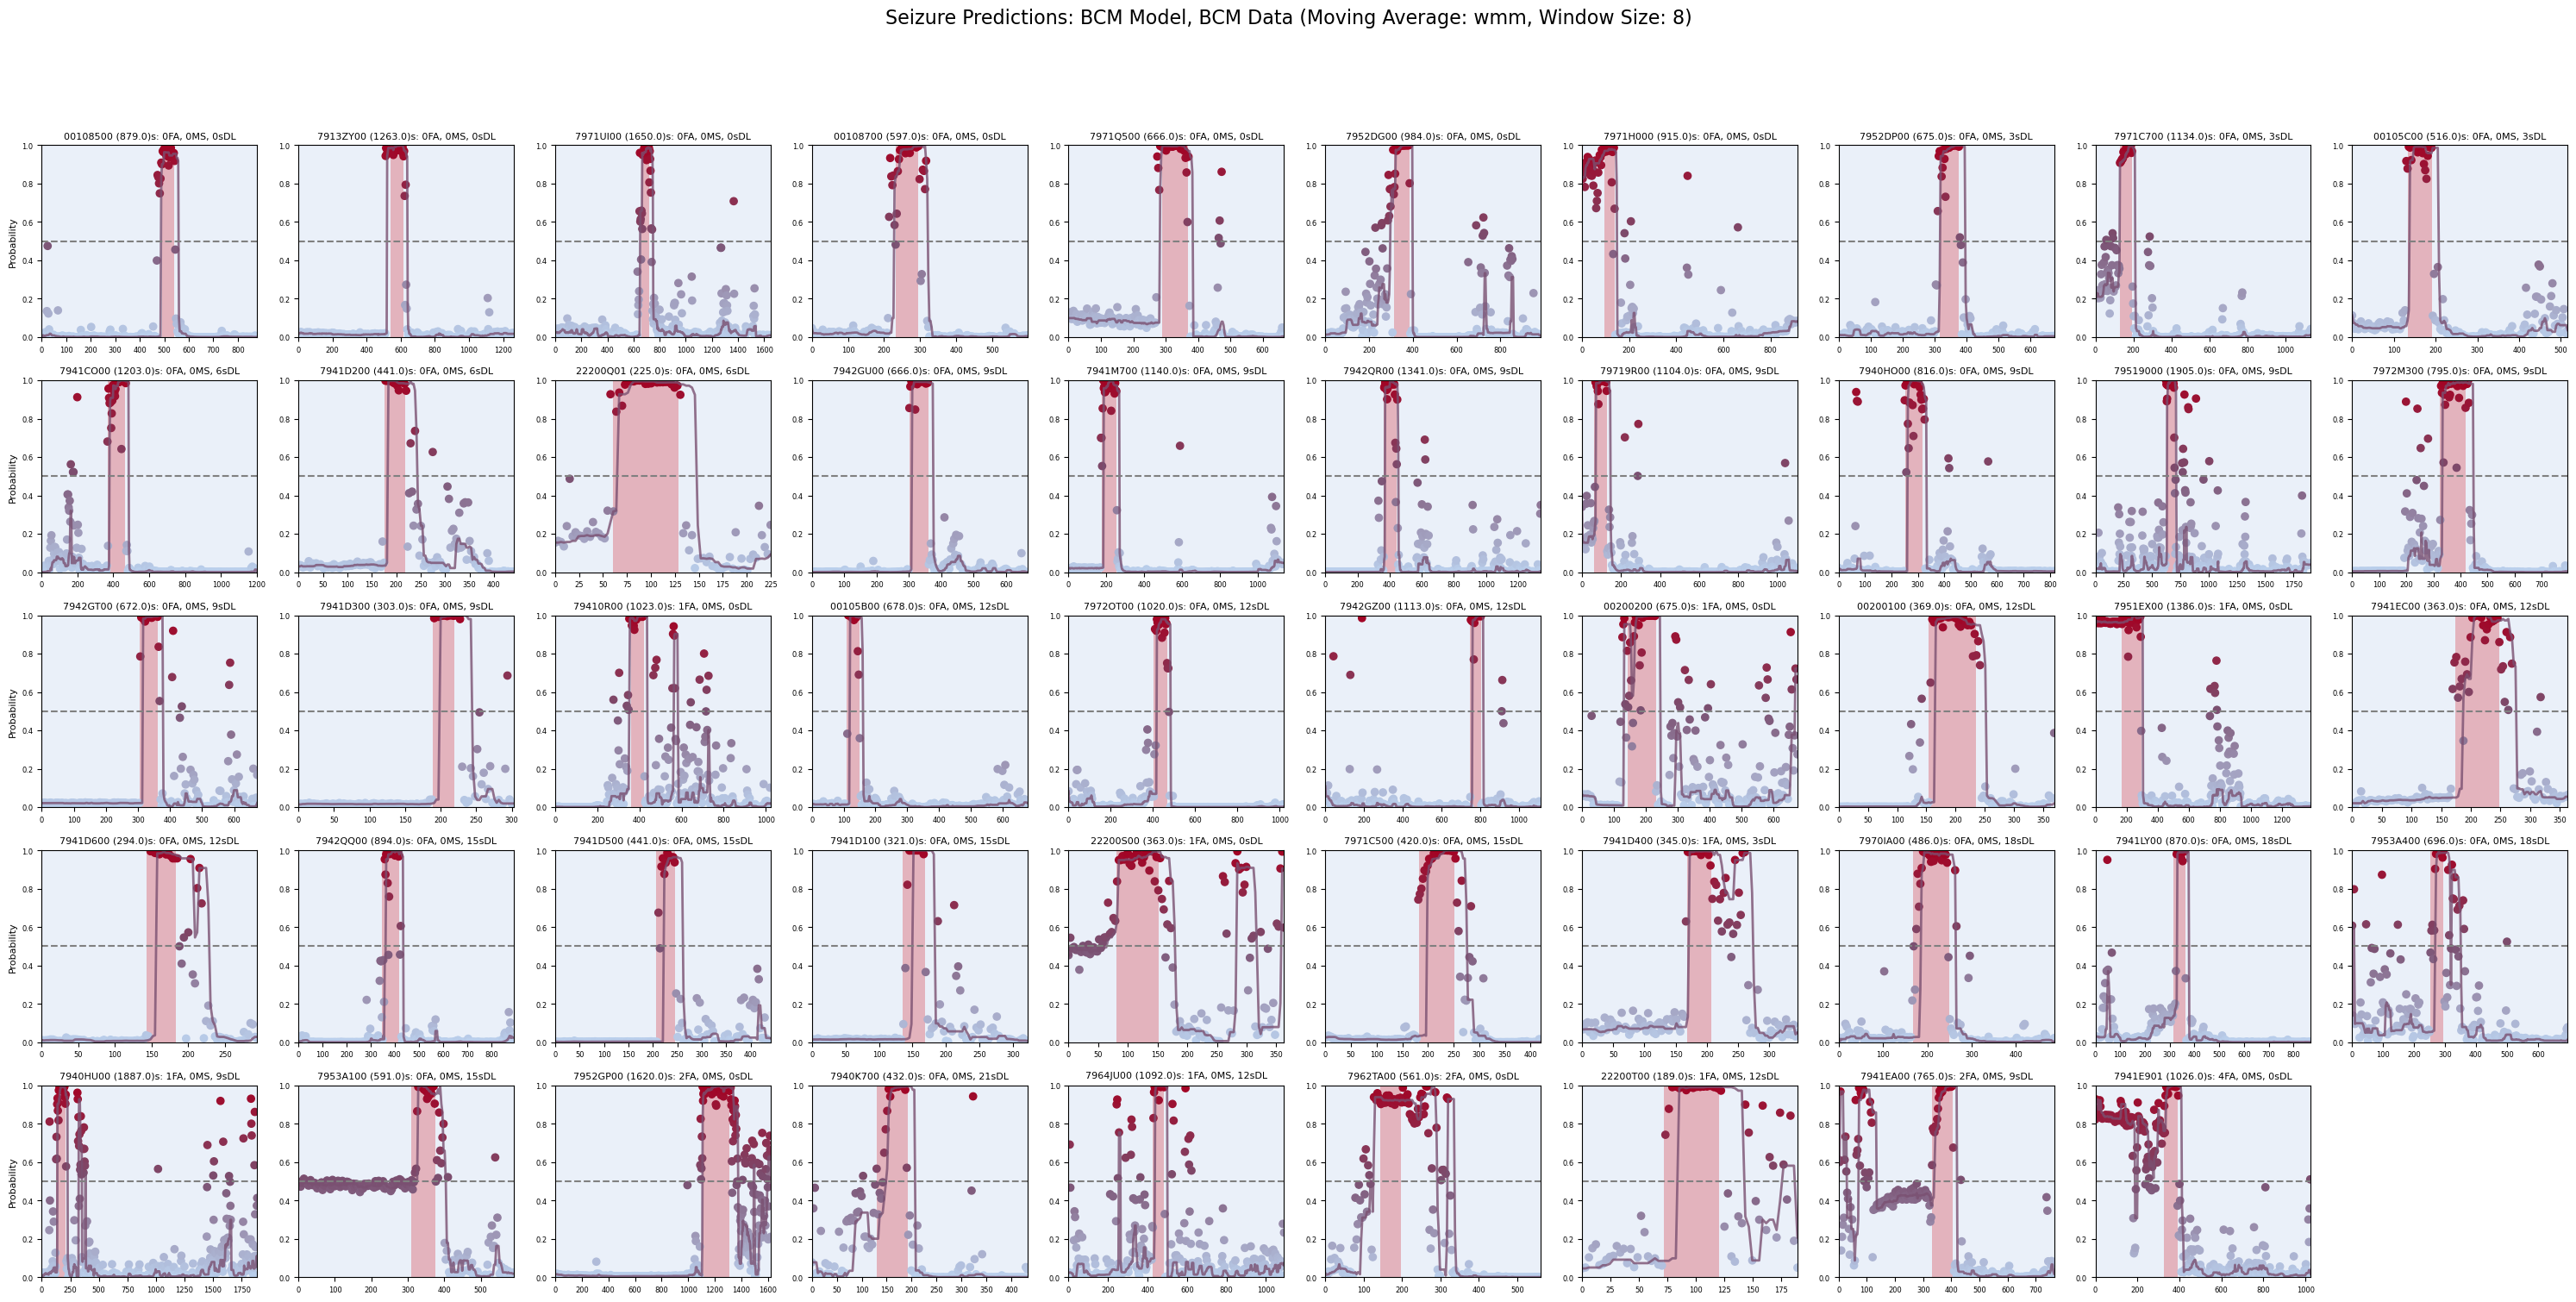

In [113]:
BCMM_BCMD = predictions_df.iloc[0:49].reset_index()
combined_plot_BCMM_BCMD_sorted = combine_seizure_predictions_sorted(av_type='wmm', k=8, df=BCMM_BCMD,
                                                                    title='Seizure Predictions: BCM Model, BCM Data',
                                                                    save_title='BCMM_BCMD')
plt.show()

<Figure size 640x480 with 0 Axes>

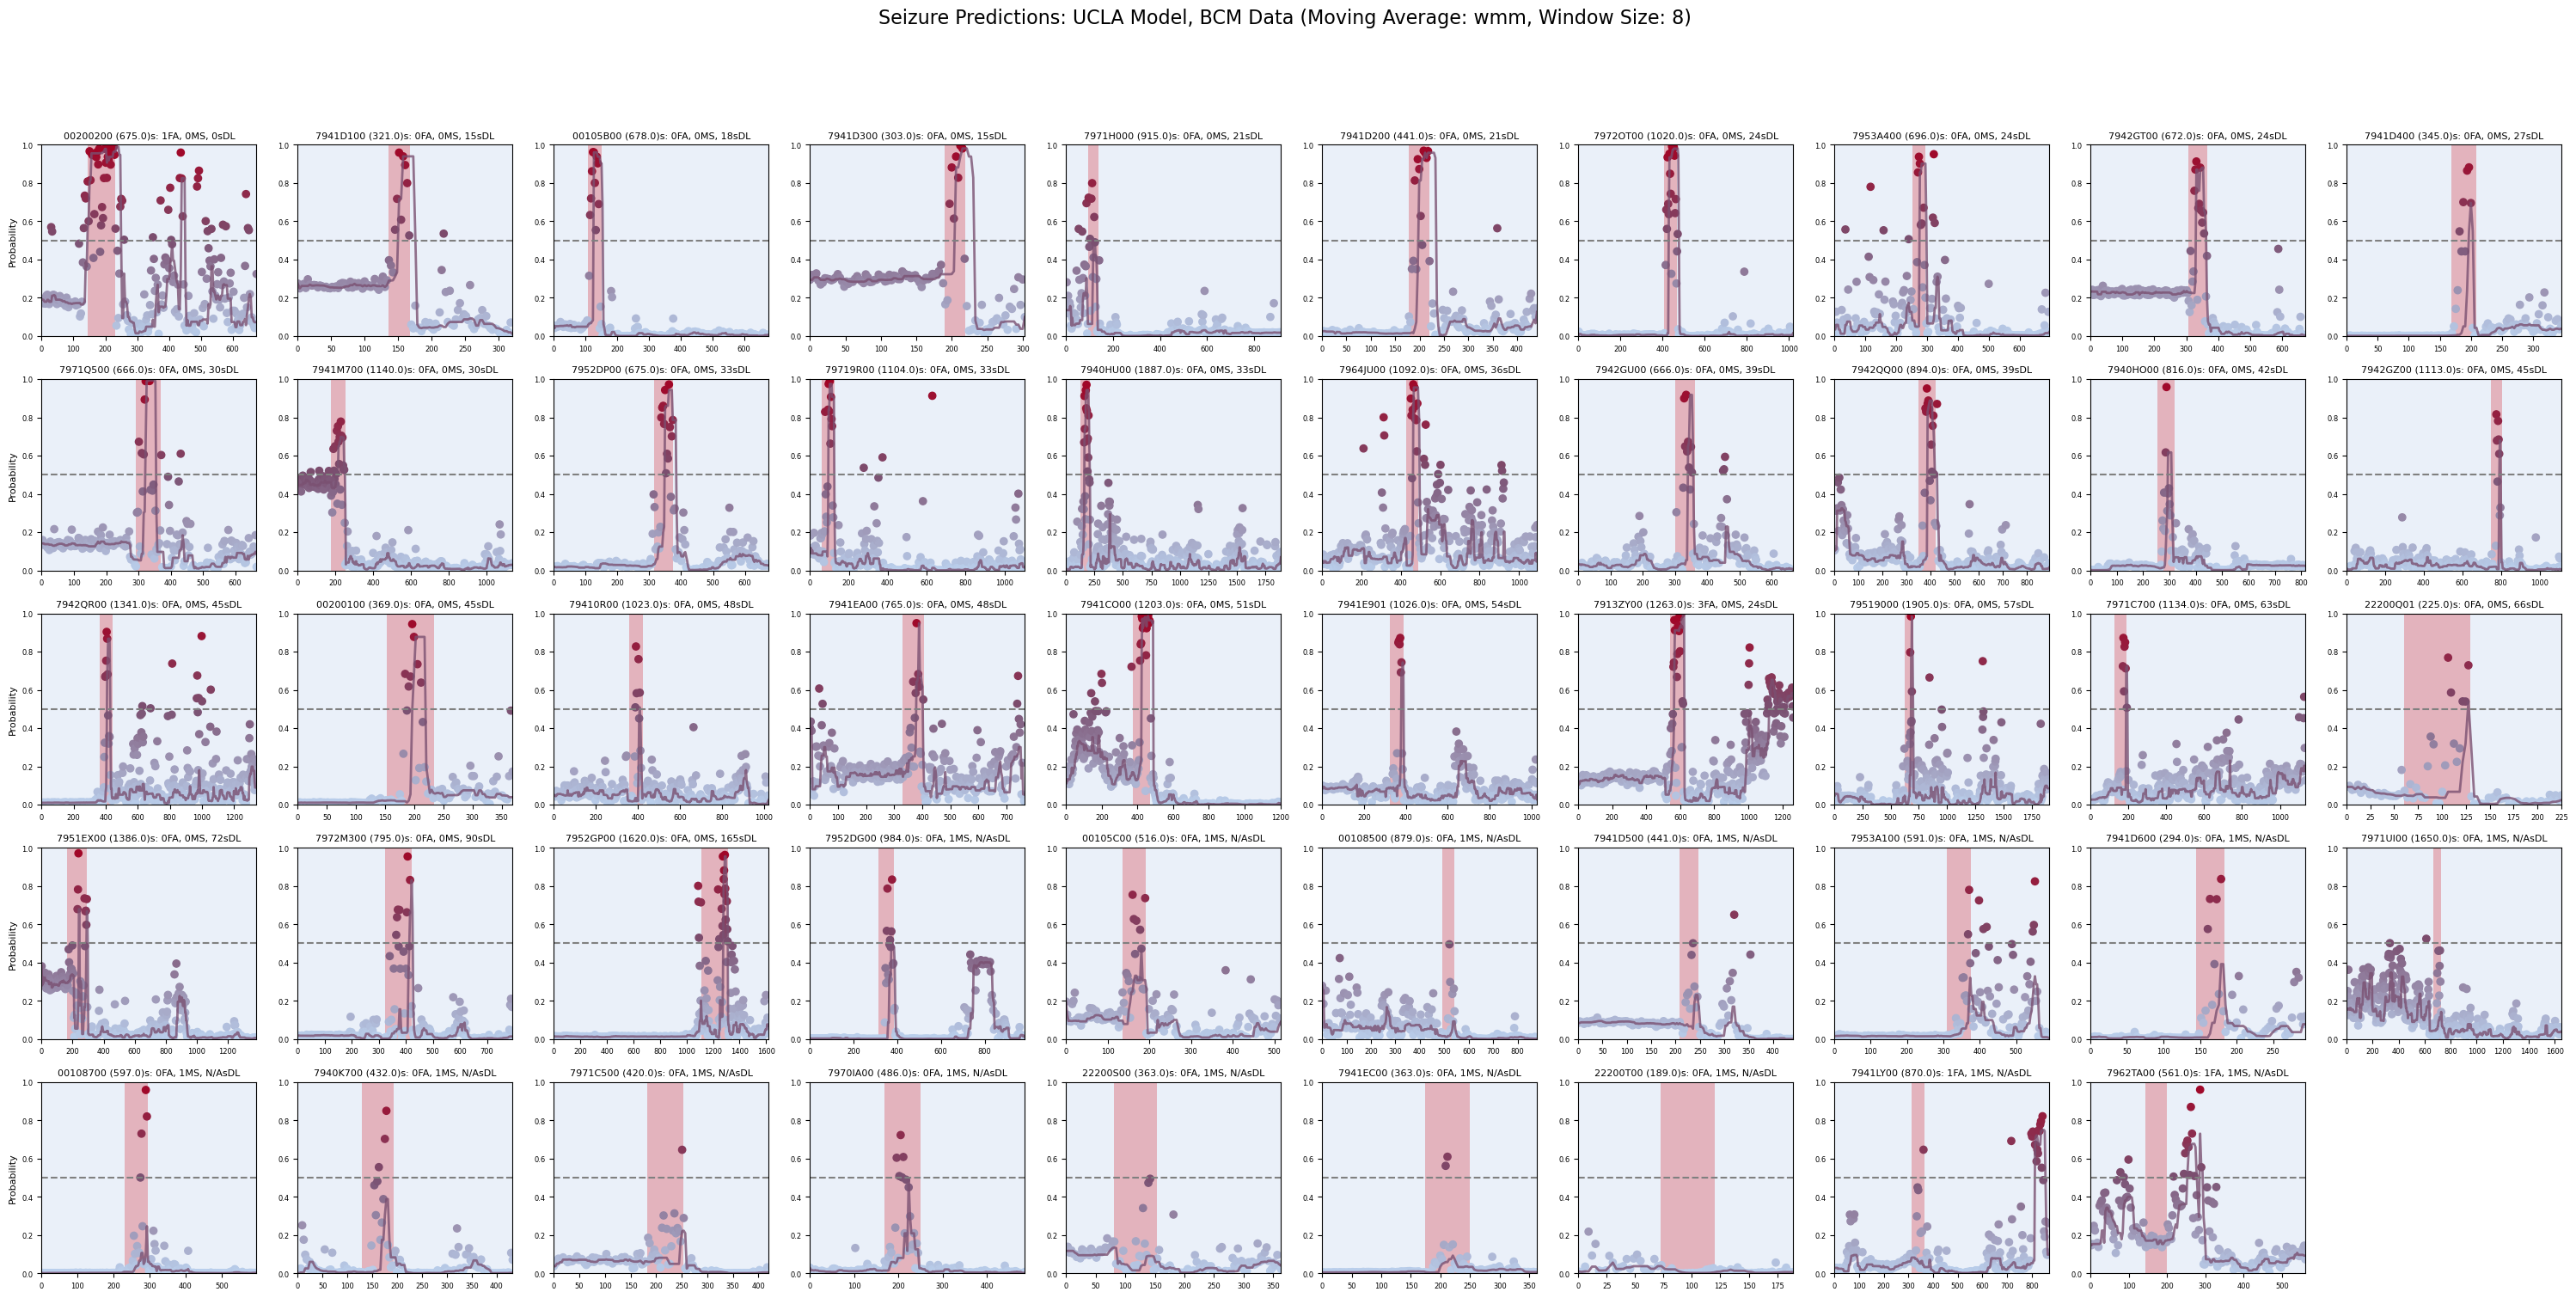

In [114]:
UCLAM_BCMD = predictions_df.iloc[49:].reset_index()
combined_plot_UCLAM_BCMD_sorted = combine_seizure_predictions_sorted(av_type='wmm', k=8, df=UCLAM_BCMD, 
                                                                     title='Seizure Predictions: UCLA Model, BCM Data',
                                                                     save_title='UCLAM_BCMD')
plt.show()

### All UCLA Videos analyzed by BCM model (0:18) and UCLA model (:end)

<Figure size 640x480 with 0 Axes>

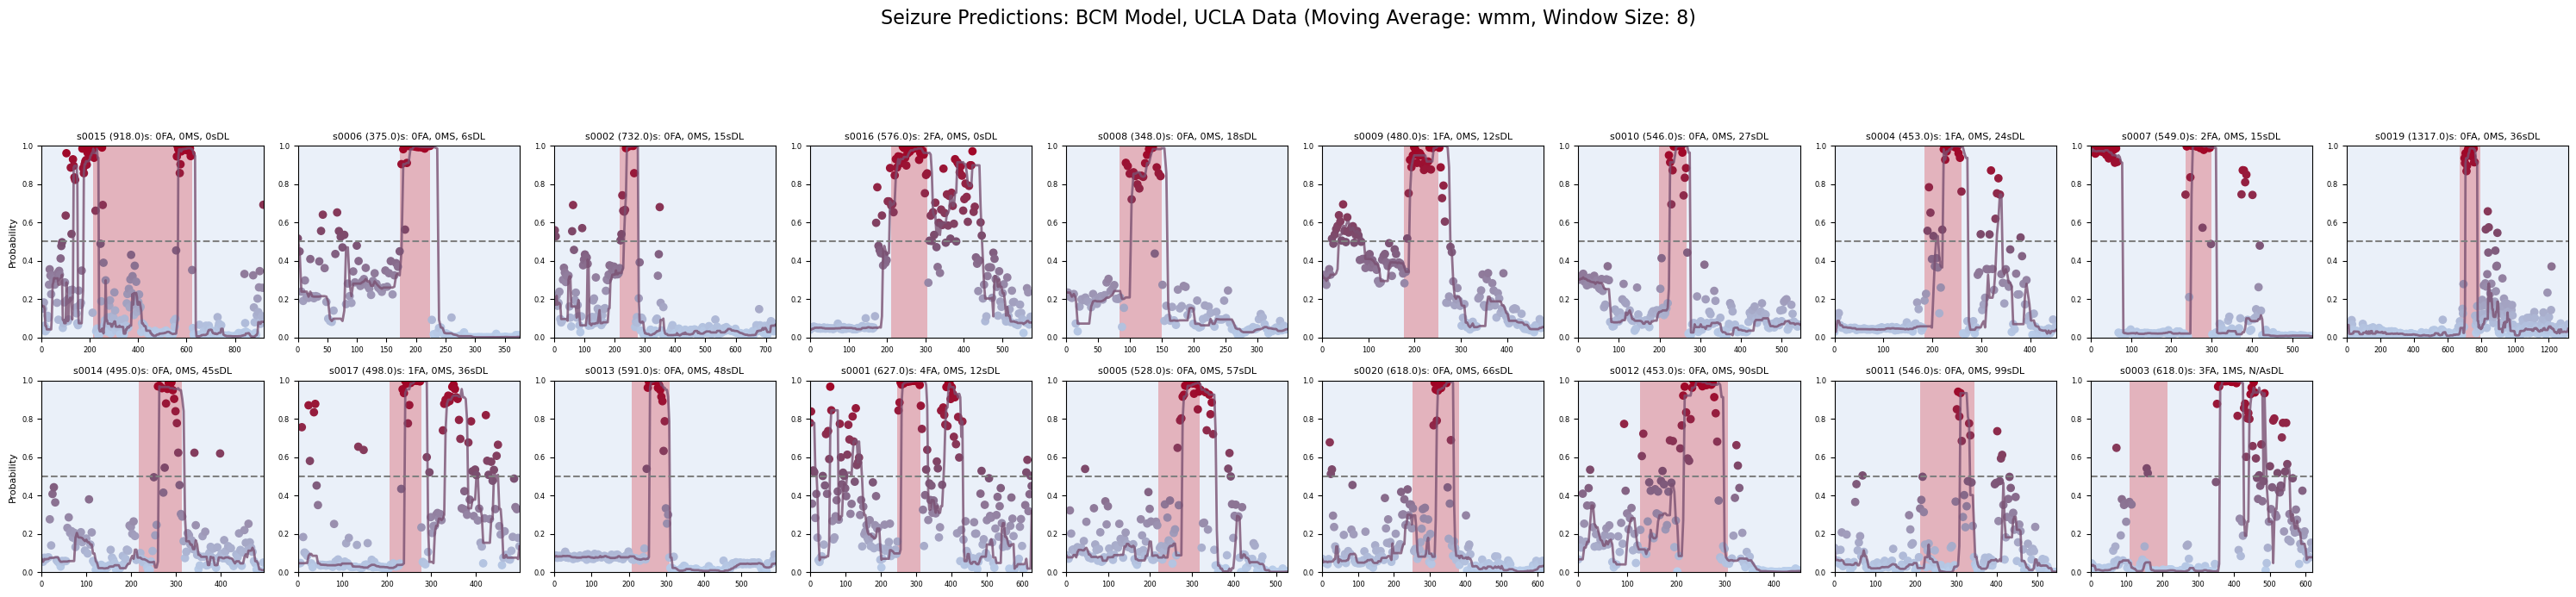

In [115]:
BCMM_UCLAD = predictions_ucla.iloc[:19].reset_index()
combined_plot_BCMM_UCLAD_sorted = combine_seizure_predictions_sorted(av_type='wmm', k=8, df=BCMM_UCLAD, video_data='UCLA',
                                                                      title='Seizure Predictions: BCM Model, UCLA Data',
                                                                      save_title = 'BCMM_UCLAD')
plt.show()

<Figure size 640x480 with 0 Axes>

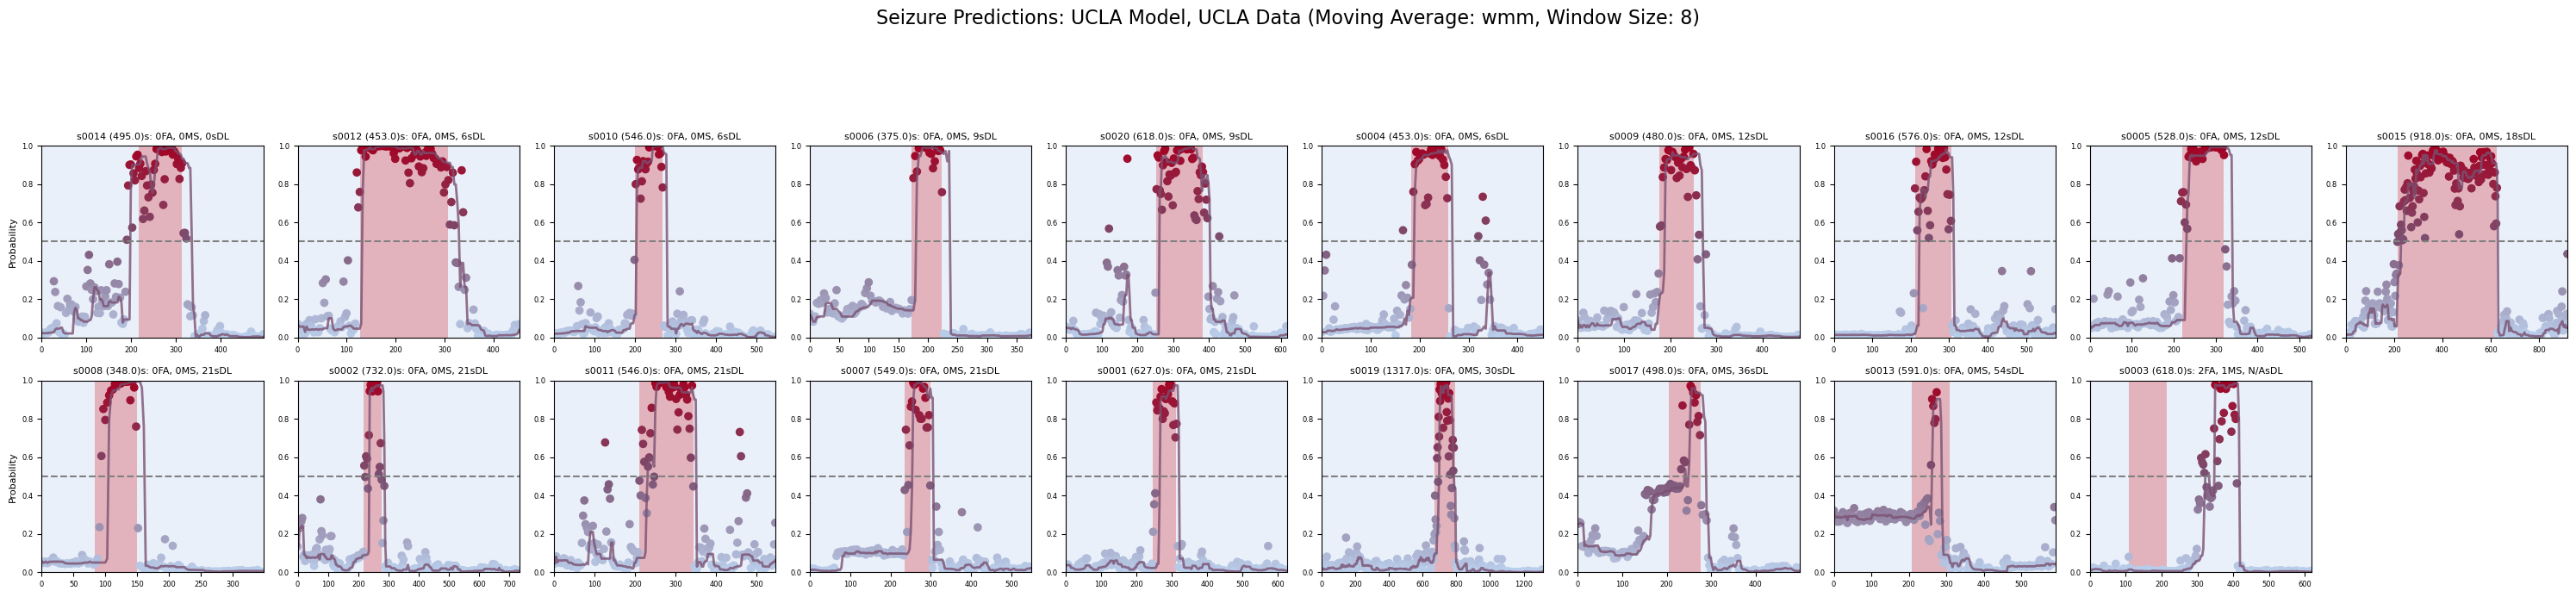

In [116]:
UCLAM_UCLAD = predictions_ucla.iloc[19:].reset_index()
combined_plot_BCMM_UCLAD_sorted = combine_seizure_predictions_sorted(av_type='wmm', k=8, df=UCLAM_UCLAD, video_data='UCLA',
                                                                     title='Seizure Predictions: UCLA Model, UCLA Data',
                                                                     save_title='UCLAM_UCLAD')
plt.show()

In [121]:
def create_alarm_report(av_type:str='wmm', k:int=8, df:pd.DataFrame = predictions_df, video_data:str = 'BCM'):
    alarms_info = []
    for row in range(0, len(df)):
        alarms_info.append(auto_false_alarm(row, av_type=av_type, k=k, df=df, video_data=video_data))
    if video_data == "BCM":
        bcm_alarms = alarms_info[0:49]
        ucla_alarms = alarms_info[49:]
    if video_data == 'UCLA':
        bcm_alarms = alarms_info[0:19]
        ucla_alarms = alarms_info[19:]

    return({
        'bcm': bcm_alarms,
        'ucla': ucla_alarms
    })
def alarms_report(alarms_dict):
    total_alarms = 0
    perfect_alarms = 0
    total_video_time = 0
    missed_seizures = 0
    latency = 0
    latencies = []
    alarms = []
    for entry in alarms_dict:
        num_alarms = entry[0]['num_false_alarms']
        total_video_time += entry[0]['total_video_time']
        missed_seizures += entry[0]['missed_seizures']
        if entry[0]['detection_latencies']:
            latency += entry[0]['detection_latencies'][0]
            latencies.append(entry[0]['detection_latencies'][0])
        total_alarms += num_alarms
        alarms.append(num_alarms)
        if num_alarms == 0: perfect_alarms += 1
    print(f'Total false alarms: {total_alarms}')
    print(f'Videos without false alarms: {perfect_alarms}/{len(alarms_dict)} ({perfect_alarms/len(alarms_dict)*100:.2f}%)')
    print(f'Total video time analyzed: {total_video_time}')
    print(f'Average false alarm rate: {total_alarms/(total_video_time/3600):.2f}/hr')
    print(f'Missed alarms: {missed_seizures}/{len(alarms_dict)} ({missed_seizures/len(alarms_dict)*100:.2f}%)')
    print(f'Average detection latency: {latency/len(alarms_dict):.2f} +/- {np.std(latencies):.2f} seconds')
    print(f'Median detection latency: {np.median(latencies):.2f} ({np.percentile(latencies, [25 ,75])}) seconds')
    return (latencies, alarms)

In [122]:
# BCM Model - BCM Data
latencies_BCMMD,_ = alarms_report(create_alarm_report(av_type='wma',k=8)['bcm'])

Total false alarms: 20
Videos without false alarms: 36/49 (73.47%)
Total video time analyzed: 39810
Average false alarm rate: 1.81/hr
Missed alarms: 0/49 (0.00%)
Average detection latency: 2.76 +/- 4.49 seconds
Median detection latency: 0.00 ([0. 3.]) seconds


<Figure size 640x480 with 0 Axes>

In [123]:
# UCLA Model - BCM Data
latencies_UCLAMBCMD,_ = alarms_report(create_alarm_report(av_type='wma', k=8)['ucla'])

Total false alarms: 7
Videos without false alarms: 44/49 (89.80%)
Total video time analyzed: 39810
Average false alarm rate: 0.63/hr
Missed alarms: 14/49 (28.57%)
Average detection latency: 24.55 +/- 22.24 seconds
Median detection latency: 33.00 ([22.5 42. ]) seconds


<Figure size 640x480 with 0 Axes>

In [124]:
# UCLA Model - UCLA Data
latencies_UCLAMD,_ = alarms_report(create_alarm_report(av_type='wma', k=8, df=predictions_ucla, video_data='UCLA')['ucla'])

Total false alarms: 2
Videos without false alarms: 18/19 (94.74%)
Total video time analyzed: 11268
Average false alarm rate: 0.64/hr
Missed alarms: 1/19 (5.26%)
Average detection latency: 9.63 +/- 13.23 seconds
Median detection latency: 6.00 ([ 3.   11.25]) seconds


<Figure size 640x480 with 0 Axes>

In [125]:
# BCM Model - UCLA Data
latencies_BCMMUCLAD,_ = alarms_report(create_alarm_report(av_type='wma', k=8, df=predictions_ucla, video_data='UCLA')['bcm'])

Total false alarms: 17
Videos without false alarms: 11/19 (57.89%)
Total video time analyzed: 11268
Average false alarm rate: 5.43/hr
Missed alarms: 1/19 (5.26%)
Average detection latency: 27.00 +/- 28.90 seconds
Median detection latency: 19.50 ([ 4.5 42. ]) seconds


<Figure size 640x480 with 0 Axes>

For BCM(M)-BCM(D) a false alarm was triggered every 26.93 min on average. 36/49 videos evaluated had no false alarms.

### Statistical Tests

In [1]:
metrics = ['f1_score', 'acc', 'AUC', 'sens', 'spec']

bcm_f1=[0.9513,0.9571,0.9507,0.9594,0.9521,0.9596,0.9612,0.9758,0.9631,0.9709,0.9628,0.9598,0.9588,0.9567,0.959,0.9598,0.9423,0.9663,0.9474,0.9565,0.9602,0.9712,0.9604,0.9652,0.9615]
bcm_acc = [0.9498,0.9569,0.95,0.9593,0.9523,0.959,0.9615,0.9758,0.9629,0.9709,0.9631,0.9596,0.9597,0.9569,0.9593,0.9595,0.9423,0.9663,0.9471,0.9569,0.9597,0.9713,0.9591,0.9648,0.9615]
bcm_AUC = [0.986,0.986,0.9864,0.9883,0.98,0.9847,0.99,0.9965,0.9914,0.9915,0.9917,0.9903,0.9883,0.9906,0.9885,0.9945,0.9824,0.9892,0.9849,0.9885,0.9901,0.9925,0.9759,0.9865,0.9915]
bcm_sens = [0.9809,0.9617,0.965,0.9617,0.9497,0.9744,0.9519,0.9758,0.9703,0.9709,0.9557,0.9646,0.9384,0.9522,0.9522,0.9667,0.9423,0.9663,0.9519,0.9492,0.9731,0.9665,0.9904,0.9749,0.9615]
bcm_spec = [0.918660287,0.95215311,0.935,0.956937799,0.954773869,0.943589744,0.971153846,0.975845411,0.955445545,0.970873786,0.97044335,0.954545455,0.981042654,0.961722488,0.966507177,0.952380952,0.942307692,0.966346154,0.942307692,0.964467005,0.946236559,0.976076555,0.927884615,0.954773869,0.961538462]

bcm_mets = [bcm_f1,bcm_acc,bcm_AUC,bcm_sens,bcm_spec]

ucla_f1=[0.9302,0.8947,0.8197,0.8889,0.9855,0.9714,0.9,0.9048,0.963,0.9787,0.8837,0.9385,0.3,0.8462,0.9927,0.9841,0.6842,0.8571,0.9263]
ucla_acc = [0.9856,0.9836,0.9466,0.9603,0.9943,0.992,0.9781,0.9655,0.9875,0.9945,0.9451,0.947,0.8579,0.9273,0.9935,0.9948,0.9277,0.9772,0.966]
ucla_AUC = [1,0.9953,1,0.9911,0.9994,0.9964,0.9989,0.9883,0.9991,1,0.9917,0.9967,0.7824,0.978,0.9999,0.9988,0.9835,1,0.9935]
ucla_sens = [0.8696,0.8095,0.6944,0.9231,1,0.9444,0.8182,0.8261,1,0.9583,0.8444,1,0.1765,1,0.9855,0.9688,0.52,0.75,1]
ucla_spec = [1,1,1,0.968,0.992957746,1,1,1,0.985074627,1,0.97810219,0.911111111,1,0.909090909,1,1,1,1,0.956790123]

ucla_mets = [ucla_f1,ucla_acc,ucla_AUC,ucla_sens,ucla_spec]

In [2]:
from scipy import stats

_, bcm_v_ucla = stats.mannwhitneyu(latencies_BCMMD, latencies_UCLAMD, alternative='less')
_, bcm_uclaxtest = stats.mannwhitneyu(latencies_BCMMD, latencies_BCMMUCLAD, alternative='less')
_, ucla_bcmxtest = stats.mannwhitneyu(latencies_UCLAMD, latencies_UCLAMBCMD, alternative='less')

print(f""" BCM vs. UCLA DL - same-site: {bcm_v_ucla}
BCM same-site vs. BCM cross-site: {bcm_v_ucla}
UCLA same-site vs. UCLA cross-site: {ucla_bcmxtest}
      """)

NameError: name 'latencies_BCMMD' is not defined

In [39]:
videos = []
timestamps = []
predictions = []
score_values = []
movement_values = []

for i in range(0, 49):
    res = seizure_predictions(i, av_type='wmm', k=8, show_plot=False, save=False)
    videos.append(res['Video_name'])
    timestamps.append(res['Video_Time'])
    predictions.append(res['Preds'])
    score_values.append(res['Scores'])
    movement_values.append(res['Degree_Movement'])

alarm_data = create_alarm_report(av_type='wma', k=8)
latencies, alarms = alarms_report(alarm_data['bcm'])


length_movement_df = pd.DataFrame({
    'video': videos,
    'time': timestamps,
    'preds': predictions,
    'scores': score_values,
    'movement': movement_values,
    'latency': latencies,
    'alarms': alarms
})

Total false alarms: 20
Videos without false alarms: 36/49 (73.47%)
Total video time analyzed: 39810
Average seconds between false alarms: 1990.5 seconds
Missed alarms: 0/49 (0.00%)
Average detection latency: 2.76 +/- 4.49 seconds
Median detection latency: 0.00 ([0. 3.]) seconds


<Figure size 640x480 with 0 Axes>

In [5]:
from scipy.stats import spearmanr, pearsonr
import seaborn as sns

# Movement (ordinal) vs Alarms (ordinal) - Spearman correlation
movement_alarms_corr, movement_alarms_p = spearmanr(length_movement_df['movement'], length_movement_df['alarms'])

# Movement (ordinal) vs Latency (continuous) - Spearman correlation
movement_latency_corr, movement_latency_p = spearmanr(length_movement_df['movement'], length_movement_df['latency'])

# Video length (continuous) vs Alarms (ordinal) - Spearman correlation
length_alarms_corr, length_alarms_p = spearmanr(length_movement_df['time'], length_movement_df['alarms'])

# Video length (continuous) vs Latency (continuous) - Pearson correlation
length_latency_corr, length_latency_p = pearsonr(length_movement_df['time'], length_movement_df['latency'])

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# sns.boxplot(x='movement', y='alarms', data=length_movement_df, ax=ax1)
# ax1.set_title(f'Movement vs Alarms\np={movement_alarms_p:.4f}')
# sns.boxplot(x='movement', y='latency', data=length_movement_df, ax=ax2)
# ax2.set_title(f'Movement vs Latency\np={movement_latency_p:.4f}')
# sns.scatterplot(x='time', y='alarms', data=length_movement_df, ax=ax3)
# ax3.set_title(f'Video Length vs Alarms\np={length_alarms_p:.4f}')
# sns.scatterplot(x='time', y='latency', data=length_movement_df, ax=ax4)
# ax4.set_title(f'Video Length vs Latency\np={length_latency_p:.4f}')

# plt.tight_layout()

results = {
    'Movement vs Alarms': {'correlation': movement_alarms_corr, 'p_value': movement_alarms_p},
    'Movement vs Latency': {'correlation': movement_latency_corr, 'p_value': movement_latency_p},
    'Video Length vs Alarms': {'correlation': length_alarms_corr, 'p_value': length_alarms_p},
    'Video Length vs Latency': {'correlation': length_latency_corr, 'p_value': length_latency_p}
}

print("\nStatistical Analysis Results:")
for relationship, stats_dict in results.items():
    print(f"\n{relationship}:")
    print(f"Correlation: {stats_dict['correlation']:.4f}")
    print(f"P-value: {stats_dict['p_value']:.4f}")

NameError: name 'length_movement_df' is not defined